In [2]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

/home/kyun/anaconda3/envs/ai_240402/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/home/kyun/anaconda3/envs/ai_240402/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do no

In [3]:
num_classes : int = 100
input_shape : list[int] = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape : {x_train.shape}, y_train shape : {y_train.shape}")
print(f"x_test shape : {x_test.shape}, y_test shape : {y_test.shape}")


x_train shape : (50000, 32, 32, 3), y_train shape : (50000, 1)
x_test shape : (10000, 32, 32, 3), y_test shape : (10000, 1)


In [4]:
batch_size : int = 256
image_size : int = 224
patch_size : int = 32
num_patches = (image_size//patch_size)**2

# D
projection_dim : int = 64
num_heads : int = 4

transformer_units : list[int] = [
    projection_dim*2,
    projection_dim,
]

transformer_layers : int = 12
mlp_head_units : list[int] = [2048, 1024]

전처리

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name = 'data_augmentation',
)

data_augmentation.layers[0].adapt(x_train)

2024-04-02 23:23:10.753467: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-02 23:23:10.959856: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-02 23:23:10.959908: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-02 23:23:10.961531: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-02 23:23:10.961637: I tensorflow/compile

In [6]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x) # Gaussian Error Linear Unit
        x = layers.Dropout(dropout_rate)(x)
    return x


In [7]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 224 X 224
Patch size: 32 X 32
Patches per image: 49
Elements per patch: 3072
Shape of patch: (1, 49, 3072)


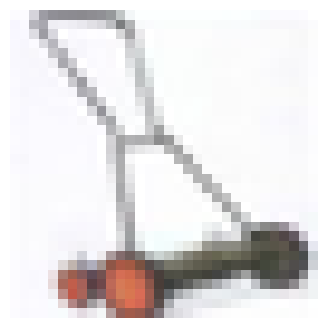

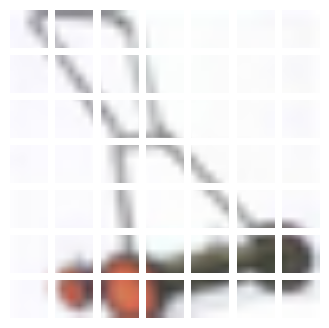

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype('uint8'))
plt.axis('off')

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), 
    size=(image_size, image_size)
)

# 생성자 (patch_size) -> 호출 (images)
patches = Patches(patch_size)(resized_image)
print(f'Image size: {image_size} X {image_size}')
print(f'Patch size: {patch_size} X {patch_size}')
print(f'Patches per image: {patches.shape[1]}')
print(f'Elements per patch: {patches.shape[-1]}')
print(f'Shape of patch: {patches.shape}')

# n=12
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4,4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i+1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype('uint8'))
    plt.axis('off')


In [10]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim = num_patches, output_dim = projection_dim
        )

    def call(self, patch):
        position = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(position)
        return encoded

In [11]:
def vit():
    inputs = layers.Input(shape=input_shape)

    augmented = data_augmentation(inputs)

    patches = Patches(patch_size)(augmented)

    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):

        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

        attention_output = layers.MultiHeadAttention(
            num_heads = num_heads, key_dim = projection_dim, dropout=0.1
        )(x1, x1) # self attention

        x2 = layers.Add()([attention_output, encoded_patches])

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)

    logits = layers.Dense(num_classes)(features)
    model = keras.Model(inputs=inputs, outputs=logits)

    return model

In [12]:
model = vit()
model.summary(0)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 data_augmentation (Sequential)  (None, 224, 224, 3)  7          ['input_1[0][0]']                
                                                                                                  
 patches_1 (Patches)            (None, None, 3072)   0           ['data_augmentation[0][0]']      
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 49, 64)       199808      ['patches_1[0][0]']              
                                                                                              

In [16]:
num_epochs = 20
weight_decay = 0.001
learning_rate = 0.001

optimizer = tfa.optimizers.AdamW(
    learning_rate = learning_rate, weight_decay = weight_decay
)

model.compile(
    optimizer = optimizer,
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
        keras.metrics.SparseTopKCategoricalAccuracy(5, name='top-5-accuracy'),
    ],
)

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.1,
)


Epoch 1/20
176/176 [==============================] - 46s 204ms/step - loss: 4.1513 - accuracy: 0.0722 - top-5-accuracy: 0.2343 - val_loss: 3.6486 - val_accuracy: 0.1480 - val_top-5-accuracy: 0.3898
Epoch 2/20
176/176 [==============================] - 35s 199ms/step - loss: 3.7015 - accuracy: 0.1297 - top-5-accuracy: 0.3651 - val_loss: 3.3994 - val_accuracy: 0.1886 - val_top-5-accuracy: 0.4434
Epoch 3/20
176/176 [==============================] - 32s 184ms/step - loss: 3.4573 - accuracy: 0.1720 - top-5-accuracy: 0.4363 - val_loss: 3.2369 - val_accuracy: 0.2088 - val_top-5-accuracy: 0.4930
Epoch 4/20
176/176 [==============================] - 32s 182ms/step - loss: 3.2978 - accuracy: 0.1996 - top-5-accuracy: 0.4758 - val_loss: 3.0809 - val_accuracy: 0.2440 - val_top-5-accuracy: 0.5352
Epoch 5/20
176/176 [==============================] - 32s 180ms/step - loss: 3.1811 - accuracy: 0.2218 - top-5-accuracy: 0.5081 - val_loss: 3.0164 - val_accuracy: 0.2554 - val_top-5-accuracy: 0.5504
Epoch

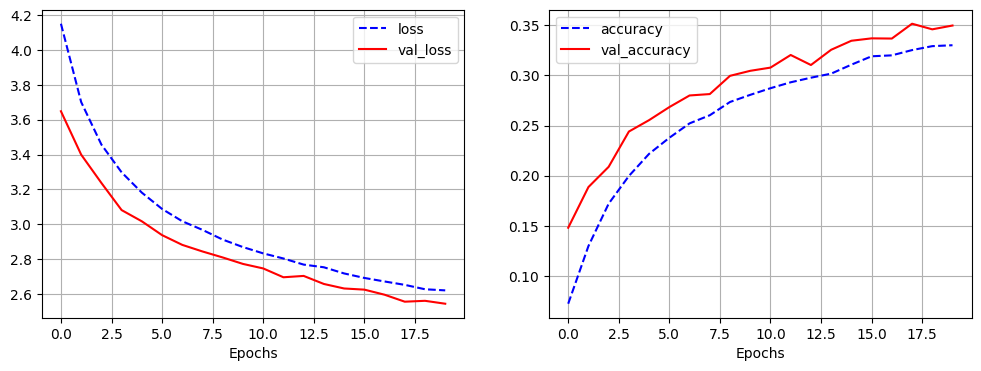

In [17]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'b--', label='loss')
plt.plot(history.history['val_loss'], 'r', label='val_loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], 'b--', label='accuracy')
plt.plot(history.history['val_accuracy'], 'r', label='val_accuracy')
plt.xlabel('Epochs')
plt.grid()
plt.legend()